>># **PROJET : Classifiez automatiquement des biens de consommation**

>>>Source du jeu de données :

>>>>>># **TRAITEE PROJET :**

# **Importation de librairies**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [7]:
# Download the NLTK resources for tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Exploration des données**

In [8]:
df_cleaned = pd.read_csv('final_df.csv')

In [9]:
df_cleaned.head()

,_category_,_category_label_,description,_clean_text_,image
0,Home Furnishing,4,Key Features of Elegance Polyester Multicolor ...,"['key', 'featur', 'eleg', 'polyest', 'multicol...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,0,Specifications of Sathiyas Cotton Bath Towel (...,"['specif', 'cotton', 'bath', 'towel', 'bath', ...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,0,Key Features of Eurospa Cotton Terry Face Towe...,"['key', 'featur', 'cotton', 'terri', 'face', '...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,4,Key Features of SANTOSH ROYAL FASHION Cotton P...,"['key', 'featur', 'royal', 'fashion', 'cotton'...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,4,Key Features of Jaipur Print Cotton Floral Kin...,"['key', 'featur', 'print', 'cotton', 'floral',...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [10]:
df_cleaned.shape

(1050, 5)

# **Modélisation avec Word2Vec**

**Chargement des données et prétraitement :**

In [11]:
import ast

In [12]:
# Conversion de la colonne '_clean_text_' en listes Python (évaluation littérale)
df_cleaned['_clean_text_'] = df_cleaned['_clean_text_'].apply(ast.literal_eval)

Séparer les colonnes de texte et d'étiquettes

In [13]:
# Séparation des textes et des étiquettes (labels)
texts = df_cleaned['_clean_text_'].tolist()
labels = df_cleaned['_category_label_'].tolist()

In [14]:
len(texts)

1050

In [15]:
texts

[['key',
  'featur',
  'eleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'eleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'pack',
  'price',
  'curtain',
  'enhanc',
  'look',
  'interior',
  'curtain',
  'made',
  'high',
  'qualiti',
  'polyest',
  'fabric',
  'featur',
  'eyelet',
  'style',
  'metal',
  'ring',
  'make',
  'room',
  'curtain',
  'anti',
  'eleg',
  'give',
  'home',
  'bright',
  'appeal',
  'design',
  'sure',
  'contemporari',
  'eyelet',
  'curtain',
  'first',
  'morn',
  'bright',
  'want',
  'good',
  'morn',
  'whole',
  'world',
  'creat',
  'special',
  'beauti',
  'print',
  'bring',
  'home',
  'eleg',
  'curtain',
  'light',
  'room',
  'get',
  'right',
  'specif',
  'eleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'pack',
  'gener',
  'brand',
  'eleg',
  'design',
  'door',
  'type',
  'e

In [16]:
len(labels)

1050

> ## **Word2Vec :**



In [17]:
!pip install gensim

In [18]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

>> Création du modèle Word2Vec

In [19]:
len(texts)

1050

In [20]:
# Création du modèle Word2Vec

w2v_size=100
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 1050 # adapt to length of texts

In [21]:
sentences = texts

In [22]:
len(sentences)

1050

In [23]:
# Préparation des sentences (tokenization)

print("Tokenisation des données textuelles...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)

# Remplacer les séquences par des séquences de même longueur
maxlen = max([len(seq) for seq in sequences])
x_sentences = pad_sequences(sequences, maxlen=maxlen)

num_words = len(tokenizer.word_index) + 1
print("Nombre de mots uniques: %i" % num_words)


Tokenisation des données textuelles...
Nombre de mots uniques: 974


In [24]:
x_sentences.shape

(1050, 268)

In [25]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=4)
#
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec entrainé")

Build & train Word2Vec model ...
Vocabulary size: 973
Word2Vec entrainé


>> Création de la matrice d'embedding

In [26]:
# Création de la matrice d'embedding

print("Création de la matrice d'embedding ...")
w2v_size = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Taux embedding word : ", word_rate)
print("Matrice d'embedding: %s" % str(embedding_matrix.shape))

Création de la matrice d'embedding ...
Taux embedding word :  1.0
Matrice d'embedding: (974, 100)


>> ### **Création du modèle de classification par approche réseaux neurones :**

In [27]:
from tensorflow.keras.utils import to_categorical

In [28]:
# Convertir les étiquettes de classe en vecteurs codés à un coup
num_classes = 7
one_hot_labels = to_categorical(labels, num_classes=num_classes)

In [29]:
x_sentences.shape

(1050, 268)

In [30]:
one_hot_labels.shape

(1050, 7)

In [31]:
# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x_sentences, one_hot_labels, test_size=0.2, random_state=42)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [33]:
# Création du modèle de classification (réseau de neurones)
model = Sequential()
model.add(Embedding(len(embedding_matrix), w2v_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))  # Utiliser l'activation "softmax" pour la classification multi-classes

In [34]:
# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# Afficher le résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 268, 100)          97400     
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 215,551
Trainable params: 118,151
Non-trainable params: 97,400
_________________________________________________________________


In [36]:
# Entraînement du modèle
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
27/27 [==============================] - 35s 1s/step - loss: 1.4366 - accuracy: 0.4940 - val_loss: 1.0016 - val_accuracy: 0.6286
Epoch 2/10
27/27 [==============================] - 13s 477ms/step - loss: 0.7591 - accuracy: 0.7726 - val_loss: 0.6085 - val_accuracy: 0.8429
Epoch 3/10
27/27 [==============================] - 13s 480ms/step - loss: 0.4425 - accuracy: 0.8643 - val_loss: 0.4224 - val_accuracy: 0.8571
Epoch 4/10
27/27 [==============================] - 13s 498ms/step - loss: 0.2873 - accuracy: 0.9143 - val_loss: 0.4098 - val_accuracy: 0.8952
Epoch 5/10
27/27 [==============================] - 13s 495ms/step - loss: 0.2119 - accuracy: 0.9381 - val_loss: 0.3252 - val_accuracy: 0.9095
Epoch 6/10
27/27 [==============================] - 13s 487ms/step - loss: 0.1487 - accuracy: 0.9476 - val_loss: 0.2949 - val_accuracy: 0.9000
Epoch 7/10
27/27 [==============================] - 14s 531ms/step - loss: 0.0878 - accuracy: 0.9702 - val_loss: 0.2862 - val_accuracy: 0.9190
Ep

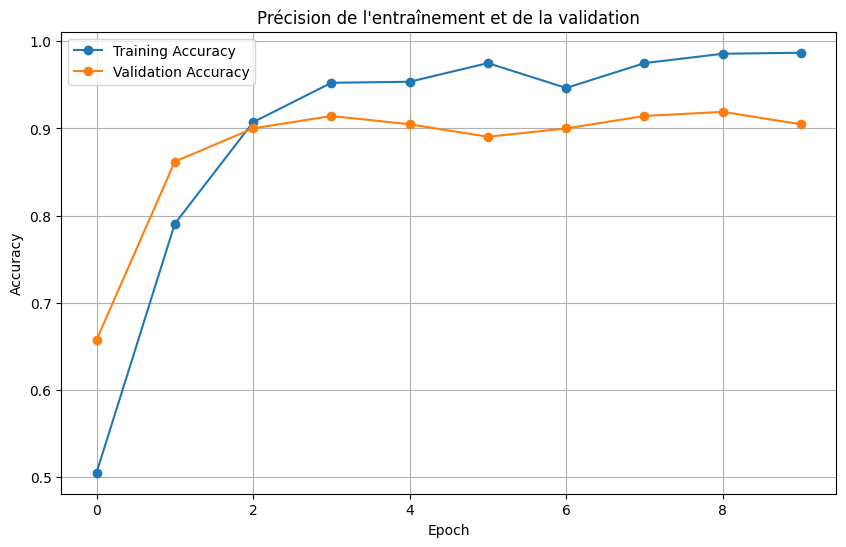

In [ ]:
# Tracer les courbes de précision de l'entraînement et de la validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Précision de l\'entraînement et de la validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

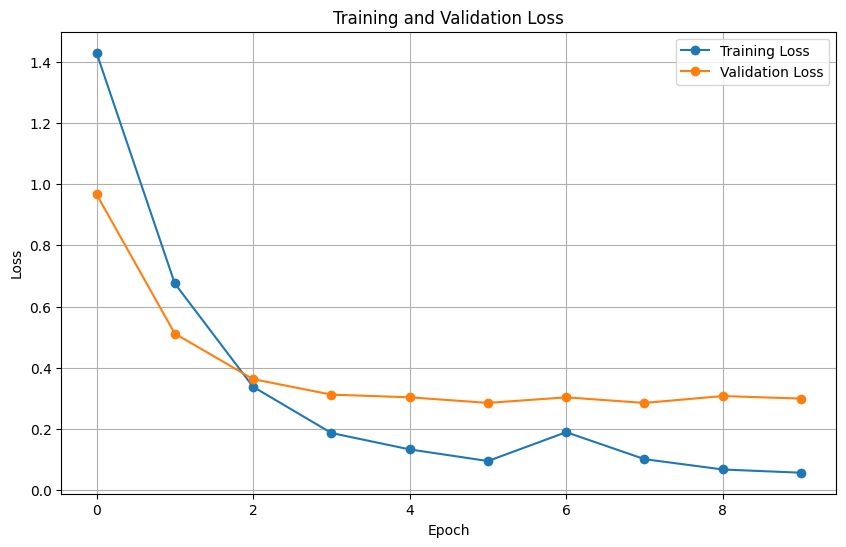

In [ ]:
# Tracer les courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

>> ### **Réduction de dimension et visualisation avec t-SNE :**

In [37]:
from sklearn.manifold import TSNE
import time
from sklearn import metrics

In [38]:
df_cleaned.head()

,_category_,_category_label_,description,_clean_text_,image
0,Home Furnishing,4,Key Features of Elegance Polyester Multicolor ...,"[key, featur, eleg, polyest, multicolor, abstr...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,0,Specifications of Sathiyas Cotton Bath Towel (...,"[specif, cotton, bath, towel, bath, towel, red...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,0,Key Features of Eurospa Cotton Terry Face Towe...,"[key, featur, cotton, terri, face, towel, set,...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,4,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, featur, royal, fashion, cotton, print, k...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,4,Key Features of Jaipur Print Cotton Floral Kin...,"[key, featur, print, cotton, floral, king, siz...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [39]:
df_cleaned._category_.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor and Festive Needs', 'Kitchen and Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [40]:
l_cat = list(set(df_cleaned._category_))
print("catégories : ", l_cat)

catégories :  ['Computers', 'Beauty and Personal Care', 'Baby Care', 'Watches', 'Home Decor and Festive Needs', 'Home Furnishing', 'Kitchen and Dining']


In [41]:
y_cat_num = [(1-l_cat.index(df_cleaned.iloc[i]['_category_'])) for i in range(len(df_cleaned))]

In [42]:
y_cat_num

[-4,
 -1,
 -1,
 -4,
 -4,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -4,
 -4,
 -4,
 -3,
 -5,
 -5,
 -4,
 -1,
 -4,
 -1,
 0,
 -5,
 -5,
 -5,
 1,
 -5,
 0,
 -5,
 1,
 -5,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -5,
 -5,
 -1,
 -4,
 -5,
 -5,
 -5,
 -4,
 -5,
 -1,
 -1,
 -1,
 0,
 0,
 -4,
 -1,
 -3,
 -3,
 -1,
 -1,
 -3,
 -3,
 -5,
 1,
 -4,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 0,
 0,
 0,
 -3,
 -3,
 -4,
 -4,
 -4,
 -1,
 -4,
 -4,
 -4,
 -1,
 -3,
 -1,
 -5,
 -1,
 1,
 -3,
 -1,
 -3,
 1,
 -4,
 -1,
 1,
 -3,
 0,
 0,
 0,
 0,
 -3,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -3,
 -3,
 -3,
 -3,
 -5,
 -3,
 -5,
 -3,
 -3,
 -1,
 -3,
 -5,
 -

In [43]:
# Obtenir les labels des features et les labels des vrais categories
embed_train = model.layers[0].get_weights()[0]
y_true_labels = df_cleaned._category_label_.values

In [44]:
print(len(embed_train))
print('\n')
embed_train

974




array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.0797178 ,  0.49720386, -0.76709735, ..., -0.65365845,
         1.79932   , -1.1468234 ],
       [ 0.6291015 , -0.34645617,  0.21209607, ..., -1.3021053 ,
         0.70575184,  0.14863873],
       ...,
       [ 0.13075347, -0.06554881, -0.18420064, ...,  0.32997748,
        -0.48412418,  0.1458357 ],
       [-0.14243159, -0.09408917,  0.23062558, ...,  1.6384878 ,
         0.6893826 ,  0.5175764 ],
       [ 0.40743375, -0.46610567,  0.09472737, ...,  0.49265966,
        -1.2046705 ,  0.18276839]], dtype=float32)

In [45]:
y_true_labels

array([4, 0, 0, ..., 0, 0, 0])

In [46]:
from sklearn import cluster, metrics

In [47]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(embed_train, true_labels) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(embed_train)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)

    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "|", "temps de T-SNE : ", "%15.2f" % time2, "secondes")

    return ARI, X_tsne, cls.labels_

In [48]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()
    print("ARI : ", ARI)

In [49]:
y_true_labels

array([4, 0, 0, ..., 0, 0, 0])

>> Création du modèle d'embedding

In [50]:
from keras.models import Model
from keras.layers import Input, Embedding, GlobalAveragePooling1D

In [51]:
# Création du modèle d'embedding

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 268)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 268, 100)          97400     
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 97,400
Trainable params: 97,400
Non-trainable params: 0
_________________________________________________________________


>> Exécution du modèle d'embedding

In [52]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 100)

In [53]:
ARI, X_tsne, labels = ARI_fct(embeddings, y_true_labels)

ARI :  0.3246 | temps de T-SNE :            17.00 secondes


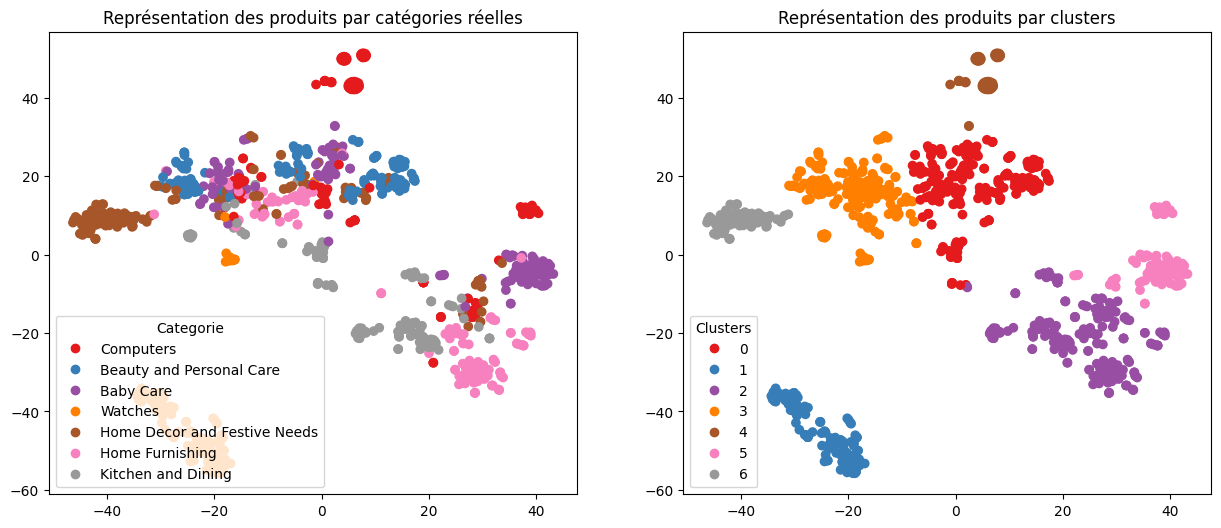

ARI :  0.3246


In [54]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# **Modélisation avec BERT**

> ## Import des librairies necessaires

In [55]:
!pip install keras

In [56]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.7 MB/s eta 0:00:00


In [57]:
from sklearn.manifold import TSNE
from sklearn import metrics
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [58]:
import time

In [59]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


> ## Fonctions communes

In [60]:
# Fonction permettant de préparer des phrases et de les tokeniser pour BERT
def prepare_sentences(sentences, max_length, tokenizer):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [61]:
# Fonction pour créer des caractéristiques BERT pour les phrases données
def feature_BERT_fct(model, model_type, sentences, max_length, batch_size, mode='HF'):
    tokenizer = BertTokenizer.from_pretrained(model_type)
    input_ids, attention_masks = prepare_sentences(sentences, max_length, tokenizer)
    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks)).batch(batch_size)

    features_bert = []
    last_hidden_states_tot = []

    start_time = time.time()

    for batch in dataset:
        input_ids, attention_mask = batch
        if mode == 'HF':
            outputs = model(input_ids, attention_mask=attention_mask)
            last_hidden_states = outputs.last_hidden_state
        else:  # 'TF'
            outputs = model(input_ids)
            last_hidden_states = outputs[0]

        features_bert.append(last_hidden_states.numpy())
        last_hidden_states_tot.append(last_hidden_states)

    features_bert = np.vstack(features_bert)
    last_hidden_states_tot = tf.concat(last_hidden_states_tot, axis=0)

    end_time = time.time()
    execution_time = end_time - start_time
    print("Temps d'execution :", execution_time, "secondes")

    return features_bert, last_hidden_states_tot

> ## **BERT HuggingFace**

In [62]:
# Conversion de la colonne '_clean_text_' en listes Python (évaluation littérale)
#df_cleaned['_clean_text_'] = df_cleaned['_clean_text_'].apply(ast.literal_eval)

In [73]:
# Séparation des textes et des étiquettes (labels)
#texts = df_cleaned['_clean_text_'].tolist()
labels = df_cleaned['_category_label_'].tolist()

In [64]:
len(texts)

1050

In [65]:
len(labels)

1050

In [66]:
# Chargement du modèle BERT (exemple avec modèle HuggingFace)
max_length = 64
batch_size = 10

# Definir BERT model et model type
model_type = 'bert-base-uncased'
model = TFBertModel.from_pretrained(model_type)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [67]:
# Obtenir les caractéristiques de BERT et les last_hidden_states
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, texts, max_length, batch_size, mode='HF')

Temps d'execution : 382.2751133441925 secondes


In [68]:
# Affichage des embeddings BERT pour chaque phrase
print(features_bert)
print('\n')
features_bert.shape

[[[-0.09993102 -0.13269599  0.43188483 ... -0.1396697   0.15274984
    0.21348614]
  [-0.1198258  -0.30376887  0.5117297  ... -0.15118793  0.64794827
    0.11419988]
  [ 0.07326494 -0.01062686  0.42106044 ... -0.29400855  0.15531349
    0.13786109]
  ...
  [ 0.04210072 -0.37174526  0.9085957  ... -0.11961485  0.25731665
   -0.05473496]
  [ 0.8515211  -0.6111616   0.57546455 ... -0.26586232 -0.421613
   -0.65379417]
  [ 0.34210232  0.4407135   0.22538659 ...  0.2533561  -0.1812183
   -0.0084931 ]]

 [[-0.30049667 -0.14161861 -0.12709752 ... -0.22980228  0.2448418
    0.00978545]
  [ 0.49951652  0.39153898  0.5809892  ... -0.15908858  0.62718904
    0.19028509]
  [ 0.84058374 -0.29900947  0.7927971  ... -0.48577902  0.3735412
   -0.5332576 ]
  ...
  [ 0.07757512 -0.04776573  0.5140503  ... -0.09744436  0.06642282
   -0.01153272]
  [ 0.15146562 -0.13323982  0.55440366 ... -0.03825559  0.16339494
   -0.0791463 ]
  [ 0.12517996 -0.09207642  0.4333082  ... -0.06279265  0.1758051
    0.022359

(1050, 64, 768)

> ## **TSNE**

In [69]:
# Remodeler last_hidden_states_tot en 2D (num_samples, num_features)
#last_hidden_states_tot = tf.reshape(last_hidden_states_tot, (last_hidden_states_tot.shape[0], -1))
#last_hidden_states_tot.shape

In [70]:
features_bert = tf.reshape(features_bert, (features_bert.shape[0], -1))
features_bert.shape

TensorShape([1050, 49152])

In [75]:
true_labels = labels

In [76]:
# Calculate ARI, t-SNE, and get labels
ARI, X_tsne, labels = ARI_fct(features_bert, true_labels)

ARI :  0.205 | temps de T-SNE :            33.00 secondes


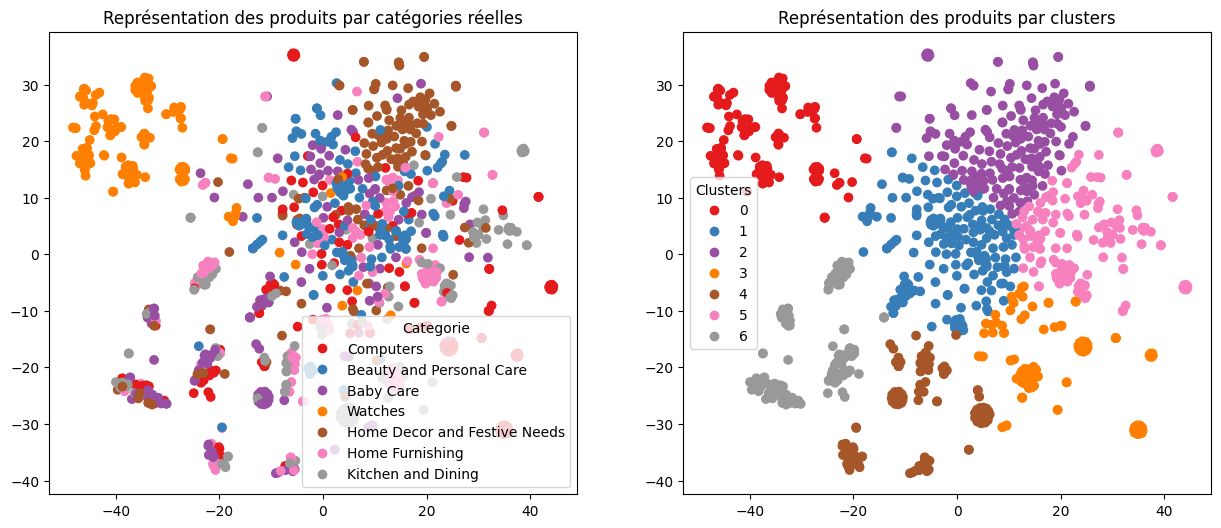

ARI :  0.205


In [77]:
# Visualize t-SNE
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# **Modélisation avec USE**

In [78]:
import time
import tensorflow as tf
import tensorflow_hub as hub
#import ast

In [79]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


In [80]:
# Chargement du modèle Universal Sentence Encoder (USE)
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_USE = hub.load(module_url)

In [81]:
# Conversion de la colonne '_clean_text_' en listes Python (évaluation littérale)
#df_cleaned['_clean_text_'] = df_cleaned['_clean_text_'].apply(ast.literal_eval)

In [82]:
# Séparation des textes et des étiquettes (labels)
#texts = df_cleaned['_clean_text_'].tolist()
#labels = df_cleaned['_category_label_'].tolist()

In [83]:
sentences

[['key',
  'featur',
  'eleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'eleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'pack',
  'price',
  'curtain',
  'enhanc',
  'look',
  'interior',
  'curtain',
  'made',
  'high',
  'qualiti',
  'polyest',
  'fabric',
  'featur',
  'eyelet',
  'style',
  'metal',
  'ring',
  'make',
  'room',
  'curtain',
  'anti',
  'eleg',
  'give',
  'home',
  'bright',
  'appeal',
  'design',
  'sure',
  'contemporari',
  'eyelet',
  'curtain',
  'first',
  'morn',
  'bright',
  'want',
  'good',
  'morn',
  'whole',
  'world',
  'creat',
  'special',
  'beauti',
  'print',
  'bring',
  'home',
  'eleg',
  'curtain',
  'light',
  'room',
  'get',
  'right',
  'specif',
  'eleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'pack',
  'gener',
  'brand',
  'eleg',
  'design',
  'door',
  'type',
  'e

In [84]:
len(sentences)

1050

In [85]:
# Fonction pour extraire les features à partir des phrases en utilisant USE
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    # Tokenize les sentences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)

    # Compléter les séquences jusqu'à une longueur maximale fixe
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Créer tf.data.Dataset pour une mise en ordre efficace
    dataset = tf.data.Dataset.from_tensor_slices(padded_sequences).batch(batch_size)

    features_list = []
    for batch_sequences in dataset:

        # Convertir les séquences en phrases
        batch_sentences = [tokenizer.sequences_to_texts([seq.numpy()])[0] for seq in batch_sequences]

        # Calculer l'embeddings avec USE model
        batch_features = model_USE(batch_sentences)
        features_list.append(batch_features.numpy())

    # Concatener toutes les features afin d'obtenir le resultat final
    features = np.concatenate(features_list, axis=0)
    time2 = np.round(time.time() - time1, 0)
    print("Temps d'exécution : ", "%15.2f" % time2, "secondes")
    return features

In [86]:
# Utilisation des fonctions adaptées
features_USE = feature_USE_fct(texts, batch_size)

Temps d'exécution :             3.00 secondes


> ## **TSNE**

In [87]:
# calculer ARI
ARI, X_tsne, labels = ARI_fct(features_USE, true_labels)

ARI :  0.3536 | temps de T-SNE :            18.00 secondes


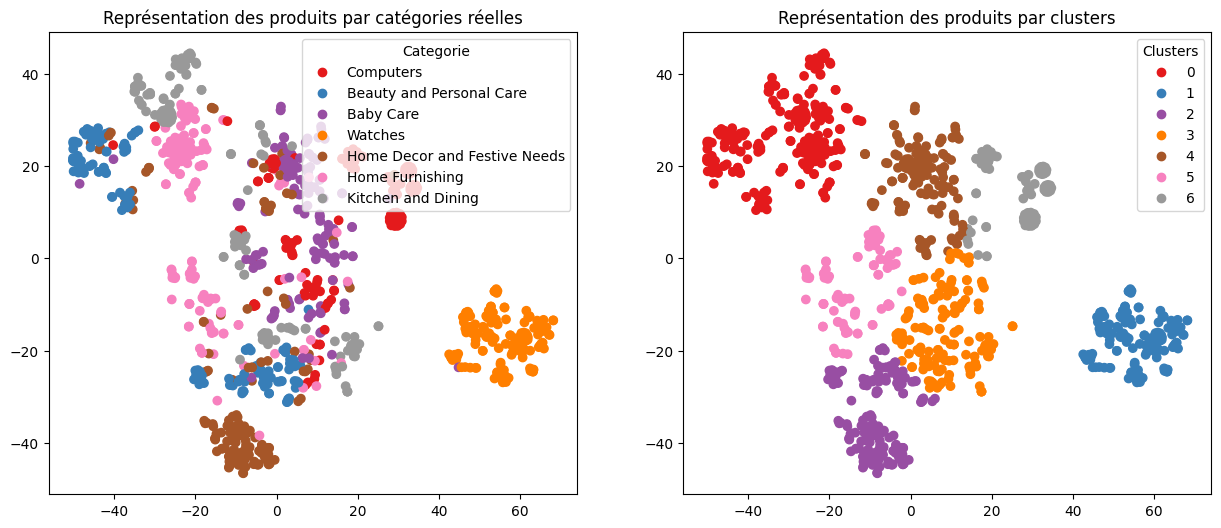

ARI :  0.3536


In [88]:
# Visualisation la T-SNE
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)